In [1]:
import numpy as np
import tensorflow as tf
import time
import pandas as pd
import matplotlib.pyplot as plt
import keras.backend.tensorflow_backend as K
from pymongo import *
from datetime import time, tzinfo, timedelta, datetime
%matplotlib inline

/usr/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/usr/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/usr/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/usr/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
Using TensorFlow backend.


In [2]:
client = MongoClient('52.79.239.183', 27017)
print("DB connection complete!!")
DB_Coin = client["BINANCE"]
Collection = DB_Coin['BTC/USD_30MIN']
import time
DB_schema = []

for collect in Collection.find():    
    temp_record = {}

    temp_record['open'] = collect['price_open']
    temp_record['close'] = collect['price_close']
    temp_record['high'] = collect['price_high']
    temp_record['low'] = collect['price_low']
    temp_record['volume'] = collect['volume_traded']    
    temp_record['Date'] = collect['time_close']
    DB_schema.append(temp_record)
    del temp_record

DB connection complete!!


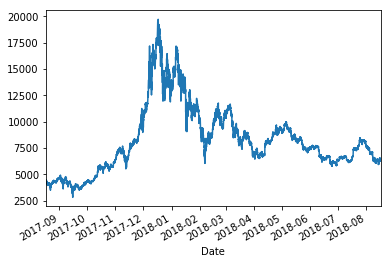

In [3]:
DF = pd.DataFrame(DB_schema)
DF['Date'] = DF['Date'].apply(pd.to_datetime, errors='coerce')
DF.index = DF['Date']
DF = DF.sort_values(by='Date')
DF['close'].plot()

In [4]:
DF = DF[['close', 'high', 'low', 'open', 'volume']]

In [5]:
split_idx = int(DF.shape[0]*0.6)
Train_DF = DF[:split_idx]
Test_DF = DF[split_idx:]

In [6]:
def Shift_DF(DF):
    for s in range(1,5):
        DF['close_shift_{}'.format(s)] = DF['close'].shift(s)        
    return DF

Train_DF = Shift_DF(Train_DF)
Test_DF = Shift_DF(Test_DF)

/home/seonwheejin/.local/lib/python3.5/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [7]:
x_train = Train_DF.dropna().drop('close', axis=1)
y_train = Train_DF.dropna()[['close']]
x_test = Test_DF.dropna().drop('close', axis=1)
y_test = Test_DF.dropna()[['close']]

x_train = x_train.values
y_train = y_train.values
x_test = x_test.values
y_test = y_test.values

from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler()
x_train = sc.fit_transform(x_train)
x_test = sc.transform(x_test)
y_train = sc.fit_transform(y_train)
y_test = sc.transform(y_test)

/usr/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/usr/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


In [8]:
print(x_train.shape)
x_train = x_train.reshape(x_train.shape[0], x_train.shape[1], 1)
x_test = x_test.reshape(x_test.shape[0], x_train.shape[1], 1)

(10414, 8)


In [9]:
from keras.layers import LSTM 
from keras.models import Sequential 
from keras.layers import Dense 
import keras.backend as K 
from keras.callbacks import EarlyStopping
np.random.seed(5)
K.clear_session() 
model = Sequential() # Sequeatial Model 
model.add(LSTM(50, input_shape=(x_train.shape[1], 1))) # (timestep, feature) 
model.add(Dense(1)) # output = 1 
model.compile(loss='mean_squared_error', optimizer='adam') 
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 50)                10400     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 51        
Total params: 10,451
Trainable params: 10,451
Non-trainable params: 0
_________________________________________________________________


In [10]:
early_stop = EarlyStopping(monitor='loss', patience=5, verbose=1)
model.fit(x_train, y_train, epochs=100, batch_size=30, verbose=1, callbacks=[early_stop])

Epoch 1/100
10414/10414 [==============================] - 8s 747us/step - loss: 0.0096
Epoch 2/100
10414/10414 [==============================] - 5s 444us/step - loss: 2.0651e-04
Epoch 3/100
10414/10414 [==============================] - 5s 444us/step - loss: 2.0465e-04
Epoch 4/100
10414/10414 [==============================] - 5s 442us/step - loss: 2.0057e-04
Epoch 5/100
10414/10414 [==============================] - 5s 443us/step - loss: 2.0077e-04
Epoch 6/100
10414/10414 [==============================] - 5s 446us/step - loss: 1.9302e-04
Epoch 7/100
10414/10414 [==============================] - 5s 442us/step - loss: 1.9065e-04
Epoch 8/100
10414/10414 [==============================] - 5s 443us/step - loss: 1.7975e-04
Epoch 9/100
10414/10414 [==============================] - 5s 446us/step - loss: 1.6806e-04
Epoch 10/100
10414/10414 [==============================] - 5s 444us/step - loss: 1.5845e-04
Epoch 11/100
10414/10414 [==============================] - 5s 445us/step - loss: 1

In [11]:
target_names = ['close']
def plot_comparison(start_idx, length=100, train=True):
    """
    Plot the predicted and true output-signals.
    :param start_idx: Start-index for the time-series.
    :param length: Sequence-length to process and plot.
    :param train: Boolean whether to use training- or test-set.
    """
    if train:
        # Use training-data.
        x = x_train
        y_true = y_train
        loss_name = "train"
    else:
        # Use test-data.
        x = x_test
        y_true = y_test
        loss_name = "test"    
    # End-index for the sequences.
    end_idx = start_idx + length
    # Select the sequences from the given start-index and
    # of the given length.
    x = x[start_idx:end_idx]
    y_true = y_true[start_idx:end_idx]
    # Input-signals for the model.
    #x = np.expand_dims(x, axis=0)
    y_pred = model.predict(x)
    test_score = model.evaluate(x, y_true, verbose=0)
    print("%s loss : %.6f" %(loss_name, test_score))
    
    # Min-Max Scaling 했던 값들을 다시 원래 스케일로 복구시킨다
    y_pred_rescaled = sc.inverse_transform(y_pred)
    y_true_rescaled = sc.inverse_transform(y_true)
    pred_label = []
    true_label = []
    
    ## initialize counter
    total_answer_count = {"Rise":0, "Fall":0, "Steady":0}
    correct_count = {"Rise":0, "Fall":0, "Steady":0}
    accuracy_result = {}

    
    ############################################################
    def get_label(numerator, denominator, label_list):
        fraction = (numerator - denominator)  / denominator
        if fraction > 0.01:
            answer = "Rise"
            
        elif fraction < -0.01:
            answer = "Fall"
            
        else:
            answer = "Steady"
            
        label_list.append(answer)
        return answer
    ############################################################

    for i in range(1, len(y_pred_rescaled)):       
        
        pred_lbl = get_label(y_pred_rescaled[i], y_pred_rescaled[i-1], pred_label)        
        total_answer_count[pred_lbl] = total_answer_count[pred_lbl] + 1
        true_lbl = get_label(y_true_rescaled[i], y_true_rescaled[i-1], true_label)
      
        if pred_lbl == true_lbl:            
            correct_count[pred_lbl] = correct_count[pred_lbl] + 1
        del pred_lbl, true_lbl
               
    def get_accuracy(Label):
        accuracy_result[Label] = correct_count[Label] / total_answer_count[Label]
    
    for key in total_answer_count.keys():        
        get_accuracy(key)
    
    print("Steady : ", correct_count["Steady"] / sum(total_answer_count.values()))
    print("total accuracy : ", sum(correct_count.values()) / sum(total_answer_count.values()))      
    #OutDF = pd.DataFrame({'True' : true_label, 'Predict' : pred_label})
    print(accuracy_result)
    

    
    
    # For each output-signal.
    for signal in range(len(target_names)):
        # Get the output-signal predicted by the model.
        signal_pred = y_pred_rescaled[:, signal]
        # Get the true output-signal from the data-set.
        signal_true = y_true_rescaled[:, signal]
        # Make the plotting-canvas bigger.
        plt.figure(figsize=(15,5))
        # Plot and compare the two signals.
        plt.plot(signal_true, label='true')
        plt.plot(signal_pred, label='pred')
        # Plot grey box for warmup-period.
        #p = plt.axvspan(0, warmup_steps, facecolor='black', alpha=0.15)
        # Plot labels etc.
        plt.ylabel(target_names[signal])
        plt.legend()
        plt.show()
    

train loss : 0.000007
Steady :  0.7243107769423559
total accuracy :  0.7819548872180451
{'Rise': 0.38461538461538464, 'Steady': 0.8233618233618234, 'Fall': 0.5909090909090909}


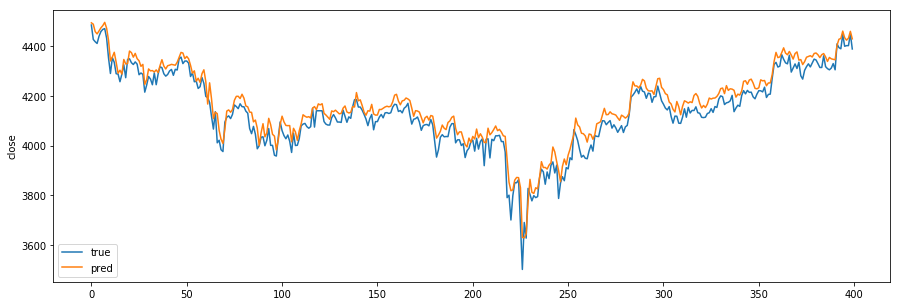

In [12]:
plot_comparison(start_idx=10, length=400, train=True)

test loss : 0.000004
Steady :  0.7894736842105263
total accuracy :  0.8671679197994987
{'Rise': 0.7222222222222222, 'Steady': 0.8974358974358975, 'Fall': 0.6}


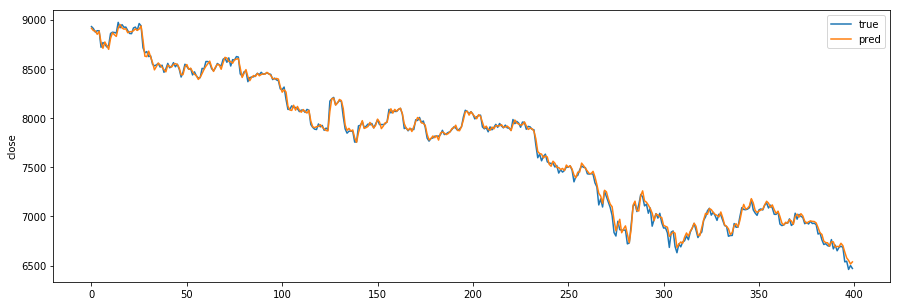

In [13]:
plot_comparison(start_idx=10, length=400, train=False)

       Fall      Rise    Steady
0  0.569231  0.605042  0.333333
1  0.582278  0.536000  0.336207


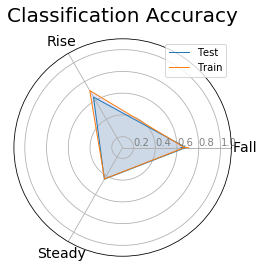

In [14]:
Test = {'Rise': 0.536, 'Fall': 0.5822784810126582, 'Steady': 0.33620689655172414}
Train = {'Rise': 0.6050420168067226, 'Fall': 0.5692307692307692, 'Steady': 0.3333333333333333}
Accuracy_DF = pd.DataFrame([Train, Test])
print(Accuracy_DF)
from Visualize_accuracy import Spider_plot
Spider_plot(Accuracy_DF)